In [1]:
import findspark
findspark.init()  # 自动定位 Spark 安装路径

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

#### 阶段 1: 初始化 Spark 环境

In [2]:
spark = SparkSession.builder \
    .appName("FoodClustering") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

25/04/24 11:15:14 WARN Utils: Your hostname, zhuwentaodeMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
25/04/24 11:15:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 11:15:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 阶段 2: 数据加载与探索

In [3]:
df = spark.read \
    .option("sep", "\t") \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("en.openfoodfacts.org.products.csv.gz")

In [4]:
print(f"原始数据量: {df.count()} 条记录")
print("字段示例:", df.columns)  # 打印前10个字段

原始数据量: 3800072 条记录
字段示例: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by', 'last_updated_t', 'last_updated_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'brands_en', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'ingredients_tags', 'ingredients_analysis_tags', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutrition_data', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_gra

##### 2.1 数据质量分析（可视化）

In [11]:
sample_pdf = df.sample(fraction=0.01, seed=42).toPandas()

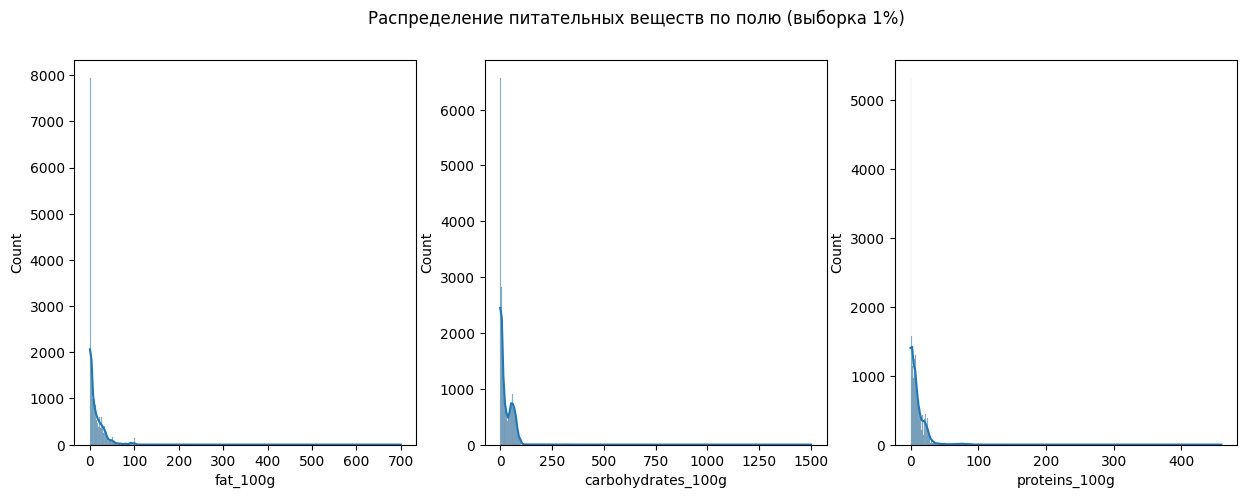

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(sample_pdf["fat_100g"].dropna(), ax=axes[0], kde=True)
sns.histplot(sample_pdf["carbohydrates_100g"].dropna(), ax=axes[1], kde=True)
sns.histplot(sample_pdf["proteins_100g"].dropna(), ax=axes[2], kde=True)
plt.suptitle("Распределение питательных веществ по полю (выборка 1%)")
plt.show()

#### 阶段 3: 数据预处理

In [13]:
selected_columns = ["fat_100g", "carbohydrates_100g", "proteins_100g"]
df_clean = df.select([col(c).cast("float") for c in selected_columns]).na.drop()

print(f"清洗后数据量: {df_clean.count()} 条")
print("缺失值已全部删除")

清洗后数据量: 2763542 条
缺失值已全部删除


In [14]:
# 定义合理范围（根据食品科学常识）
VALID_RANGE = {
    "fat_100g": (0, 100),              # 脂肪含量 0-100g/100g
    "carbohydrates_100g": (0, 100),    # 碳水 0-100g/100g
    "proteins_100g": (0, 100)          # 蛋白质 0-100g/100g
}

# 清洗异常值（超出范围和负值视为缺失）
for column, (lower, upper) in VALID_RANGE.items():
    df_clean = df_clean.withColumn(
        column,
        when((col(column) >= lower) & (col(column) <= upper), col(column)).otherwise(None)
    )

# 删除包含任何缺失值的行
df_clean = df_clean.na.drop()
df_clean.count()

2744493

In [15]:
df_clean.select(selected_columns).summary().show()

+-------+------------------+------------------+------------------+
|summary|          fat_100g|carbohydrates_100g|     proteins_100g|
+-------+------------------+------------------+------------------+
|  count|           2744493|           2744493|           2744493|
|   mean| 13.40041353221922| 27.50018937956489|  9.41365232661908|
| stddev|17.159091587717715|27.415774238425346|11.279382419729233|
|    min|               0.0|               0.0|               0.0|
|    25%|               0.9|              3.57|              1.61|
|    50%|               7.0|         15.107914|               6.4|
|    75%|             20.75|              51.5|              13.0|
|    max|             100.0|             100.0|             100.0|
+-------+------------------+------------------+------------------+



#### 阶段 4: 特征工程

In [16]:
# 向量化
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
df_features = assembler.transform(df_clean)

In [17]:
# 标准化
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [18]:
df_scaled.select("scaled_features").show(5, truncate=False)

+------------------------------------------------------------+
|scaled_features                                             |
+------------------------------------------------------------+
|[0.6760023634400011,-0.8936530176568251,1.2045293942349227] |
|[1.7832870878597766,0.09118147088215184,-0.2051222607667205]|
|[-0.6236002313895538,-0.9702512565239413,1.825130748060479] |
|[-0.7809512213228613,-0.05471993482732623,-0.74593200350254]|
|[-0.7809512213228613,0.8498687527429531,-0.7636634696978208]|
+------------------------------------------------------------+
only showing top 5 rows



In [19]:
df_sampled = df_scaled.sample(fraction=0.1, seed=42)
print(f"采样后数据量: {df_sampled.count()} 条")

采样后数据量: 274410 条


In [20]:
df_sampled.select(selected_columns).summary().show()

+-------+------------------+------------------+------------------+
|summary|          fat_100g|carbohydrates_100g|     proteins_100g|
+-------+------------------+------------------+------------------+
|  count|            274410|            274410|            274410|
|   mean|13.411182953163735|27.555791925317635|  9.40764972320081|
| stddev|17.139132238572305|27.440532674429345|11.258110567648313|
|    min|               0.0|               0.0|               0.0|
|    25%|             0.923|              3.57|              1.68|
|    50%|               7.0|              15.2|               6.4|
|    75%|         20.930233|              51.5|              13.0|
|    max|             100.0|             100.0|             100.0|
+-------+------------------+------------------+------------------+



#### 阶段 5: 模型训练

In [21]:
# 训练 K-Means 模型
kmeans = KMeans(k=3, featuresCol="scaled_features", seed=42)
model = kmeans.fit(df_sampled)

25/04/24 11:33:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/24 11:33:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [22]:
predictions = model.transform(df_sampled)

In [23]:
# 计算评估指标
inertia = model.summary.trainingCost
print(f"聚类惯性值 (Inertia): {inertia:.2f}")

聚类惯性值 (Inertia): 400268.73


#### 阶段 6: 结果可视化

In [24]:
result_pdf = predictions.sample(fraction=0.1, seed=42).toPandas()

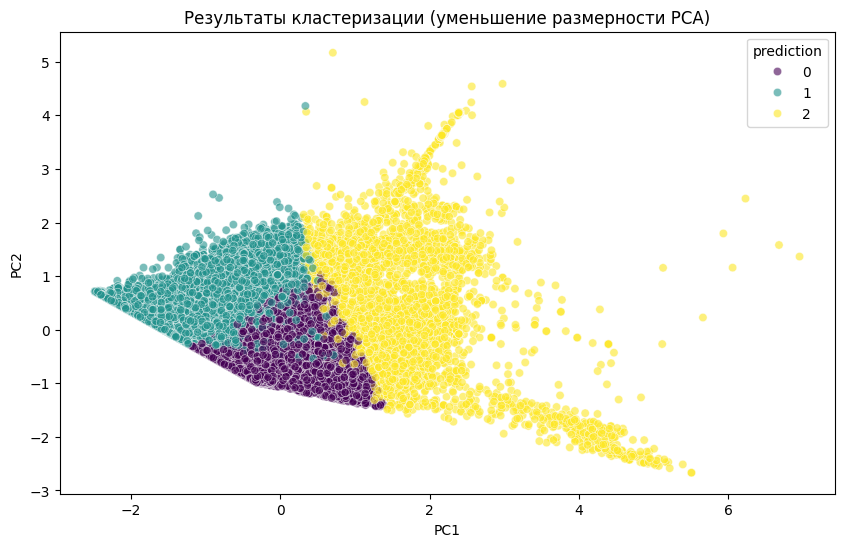

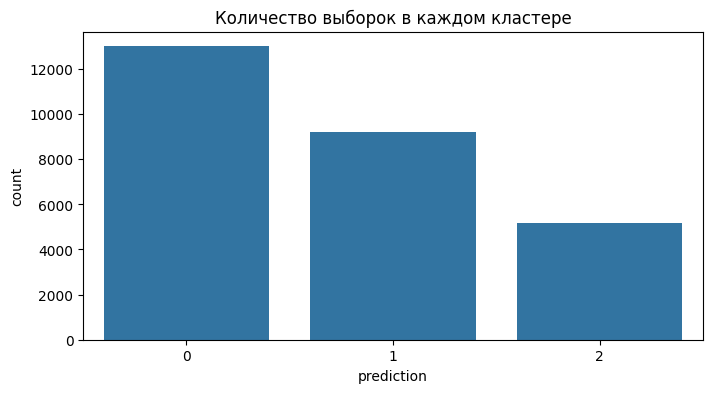

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result_pdf["scaled_features"].tolist())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], 
                hue=result_pdf["prediction"], palette="viridis", alpha=0.6)
plt.title("Результаты кластеризации (уменьшение размерности PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 聚类分布条形图
plt.figure(figsize=(8, 4))
sns.countplot(x="prediction", data=result_pdf)
plt.title("Количество выборок в каждом кластере")
plt.show()

In [26]:
model_path = "./models/kmeans"
try:
    model.save(model_path)
    print(f"模型已保存至: {os.path.abspath(model_path)}")
except Exception as e:
    print(f"模型保存失败: {str(e)}")

模型已保存至: /Users/zwt/Desktop/github_project/spark-lab/models/kmeans
